In [1]:
 !pip install d2l mxnet
import d2l
from mxnet import gluon, np, npx, autograd
from mxnet.gluon import nn
import mxnet as mx
import random
import sys
import pandas as pd
import os
npx.set_np()

You should consider upgrading via the '/home/dawid/software/python3.7-env/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
class Caser(nn.Block):
    def __init__(self, num_factors, num_users, num_items, L=3, d=16,
                 d_prime=4, drop_ratio=0.05, **kwargs):
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = nn.Conv2D(d_prime, (L, 1), in_channels=1)
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = nn.Sequential(), nn.Sequential()
        for i in h:
            self.conv_h.add(nn.Conv2D(d, (i, num_factors), in_channels=1))
            self.max_pool.add(nn.MaxPool1D(L - i + 1))
        # Fully-connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h)
        self.fc = nn.Dense(in_units=d_prime * num_factors + d * L,
                           activation='relu', units=num_factors)
        self.Q_prime = nn.Embedding(num_items, num_factors * 2)
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, user_id, seq, item_id):
        item_embs = np.expand_dims(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = np.squeeze(npx.relu(conv(item_embs)), axis=3)
                t = maxp(conv_out)
                pool_out = np.squeeze(t, axis=2)
                out_hs.append(pool_out)
            out_h = np.concatenate(out_hs, axis=1)
        out = np.concatenate([out_v, out_h], axis=1)
        z = self.fc(self.dropout(out))
        x = np.concatenate([z, user_emb], axis=1)
        q_prime_i = np.squeeze(self.Q_prime(item_id))
        b = np.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
        return res

In [3]:
class SeqDataset(gluon.data.Dataset):
    def __init__(self, user_ids, item_ids, L, num_users, num_items,
                 candidates):
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        sort_idx = np.array(sorted(range(len(user_ids)),
                                   key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        temp, u_ids, self.cand = {}, u_ids.asnumpy(), candidates
        self.all_items = set([i for i in range(num_items)])
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])
        idx = np.array([i[1][0] for i in temp])
        self.ns = ns = int(sum([c - L if c >= L + 1 else 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        self.seq_items = np.zeros((ns, L))
        self.seq_users = np.zeros(ns, dtype='int32')
        self.seq_tgt = np.zeros((ns, 1))
        self.test_seq = np.zeros((num_users, L))
        test_users, _uid = np.empty(num_users), None
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                self.test_seq[uid][:] = i_seq[-L:]
                test_users[uid], _uid = uid, uid
            self.seq_tgt[i][:] = i_seq[-1:]
            self.seq_items[i][:], self.seq_users[i] = i_seq[:L], uid

    def _win(self, tensor, window_size, step_size=1):
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size:i]
                else:
                    break
        else:
            yield tensor

    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)

    def __len__(self):
        return self.ns

    def __getitem__(self, idx):
        neg = list(self.all_items - set(self.cand[int(self.seq_users[idx])]))
        i = random.randint(0, len(neg) - 1)
        return (self.seq_users[idx], self.seq_items[idx], self.seq_tgt[idx],
                neg[i])


In [4]:
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [5]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [6]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [7]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(
        train_set, shuffle=True, last_batch='rollover',
        batch_size=batch_size)
    test_iter = gluon.data.DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

In [8]:
TARGET_NUM, L, batch_size = 1, 3, 4096
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items, candidates)
num_workers = 0 if sys.platform.startswith("win") else 4
train_iter = gluon.data.DataLoader(train_seq_data, batch_size, True,
                                   last_batch="rollover",
                                   num_workers=num_workers)
test_seq_iter = train_seq_data.test_seq
train_seq_data[0]

(array(0, dtype=int32), array([110., 255.,   4.]), array([101.]), 1486)

In [9]:
class BPRLoss(gluon.loss.Loss):
    def __init__(self, weight=None, batch_axis=0, **kwargs):
        super(BPRLoss, self).__init__(weight=None, batch_axis=0, **kwargs)

    def forward(self, positive, negative):
        distances = positive - negative
        loss = - np.sum(np.log(npx.sigmoid(distances)), 0, keepdims=True)
        return loss

In [10]:
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, ctx_list, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, ctx_list))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[0:-1])]
                p_neg = [net(*t) for t in zip(*input_data[0:-2],
                                              input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean()/len(ctx_list)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                          candidates, num_users, num_items,
                                          ctx_list)
                animator.add(epoch + 1, (hit_rate,0))
    print('train loss %.3f, test hit rate %.3f'
          % (metric[0] / metric[1], hit_rate))
    print('%.1f examples/sec on %s'
          % (metric[2] * num_epochs / timer.sum(), ctx_list))

In [11]:
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     ctx):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(*x),
                                               shuffle=False,
                                               last_batch="keep",
                                               batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [gluon.utils.split_and_load(v, ctx, even_split=False)
                 for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [12]:
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc


train loss nan, test hit rate 0.075
11.9 examples/sec on [cpu(0)]


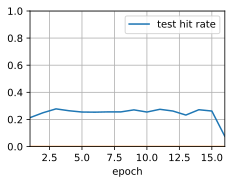

In [13]:
ctx = d2l.try_all_gpus()
net = Caser(20, num_users, num_items, 3)
net.initialize(ctx=ctx, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.2, 16, 1e-5, 'adam'
loss = BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, ctx, evaluate_ranking,
                  candidates, eval_step=1)